## Experimenting with Sentiment Analysis (to be continued)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#The data
corpus_root = 'books/'

In [2]:
df15 = pd.read_csv("../Downloads/df15.csv")
df16 = pd.read_csv("../Downloads/df16.csv")
df17 = pd.read_csv("../Downloads/df17.csv")
df18 = pd.read_csv("../Downloads/df18.csv")
df19 = pd.read_csv("../Downloads/df19.csv")
df20 = pd.read_csv("../Downloads/df20.csv")

In [3]:
words = ['lesbian', 'gay', 'homosexual', 'gender', 'bisexual', 'sexuality', 'same sex',
         'asexual', 'biphobia', 'bisexual', 'coming out', 'coming-out', 'gender identity',
        'queer', 'genderqueer', 'gender-queer', 'homophobia', 'LGBTQ', 'LGBT', 'LGBTQ+', 'LGBTQIA',
        'lgbtq', 'lgbt', 'lgbtq+', 'lgbtqia', 'non binary', 'non-binary', 'transgender'] 

In [4]:
# a lot of quotes with "bi" and "ally" aren't relevant so remove the rows that include these and don't include other relevant words 

df15 = df15[~(df15.quotation.str.contains("bi") & ~df15.quotation.isin(words))]
df15 = df15[~(df15.quotation.str.contains("ally") & ~df15.quotation.isin(words))]

df16 = df16[~(df16.quotation.str.contains("bi") & ~df16.quotation.isin(words))]
df16 = df16[~(df16.quotation.str.contains("ally") & ~df16.quotation.isin(words))]

df17 = df17[~(df17.quotation.str.contains("bi") & ~df17.quotation.isin(words))]
df17 = df17[~(df17.quotation.str.contains("ally") & ~df17.quotation.isin(words))]

df18 = df18[~(df18.quotation.str.contains("bi") & ~df18.quotation.isin(words))]
df18 = df18[~(df18.quotation.str.contains("ally") & ~df18.quotation.isin(words))]

df19 = df19[~(df19.quotation.str.contains("bi") & ~df19.quotation.isin(words))]
df19 = df19[~(df19.quotation.str.contains("ally") & ~df19.quotation.isin(words))]

df20 = df20[~(df20.quotation.str.contains("bi") & ~df20.quotation.isin(words))]
df20 = df20[~(df20.quotation.str.contains("ally") & ~df20.quotation.isin(words))]

In [17]:
# Get quotes for each year (split longer ones into two parts so they are small enough for nlp)
quotes15 = df15.quotation
quotes16 = df16.quotation
quotes17_1 = df17.quotation[0:int(df17.shape[0]/2)]
quotes17_2 = df17.quotation[int(df17.shape[0]/2):df17.shape[0]]
quotes18_1 = df18.quotation[0:int(df18.shape[0]/2)]
quotes18_2 = df18.quotation[int(df18.shape[0]/2):df18.shape[0]]
quotes19_1 = df19.quotation[0:int(df19.shape[0]/2)]
quotes19_2 =df19.quotation[int(df19.shape[0]/2):df19.shape[0]]
quotes20 = df20.quotation

In [25]:
# Create one big string from quotes
quote_string15 = '. '.join(quotes15)
quote_string16 = '. '.join(quotes16)
quote_string17_1 = '. '.join(quotes17_1)
quote_string17_2 = '. '.join(quotes17_2)
quote_string18_1 = '. '.join(quotes18_1)
quote_string18_2 = '. '.join(quotes18_2)
quote_string19_1 = '. '.join(quotes19_1)
quote_string19_2 = '. '.join(quotes19_2)
quote_string20 = '. '.join(quotes20)

In [21]:
nlp = spacy.load('en_core_web_sm')

In [22]:
# Looking at a single quote
quote1 = quotes15[70]
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(quote1)

In [23]:
print(quote1, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

if advocating for equal pay for equal work is playing the gender card, deal me in. I am ready to play as hard as I can. 

Negative sentiment: 0.092
Neutral sentiment: 0.689
Positive sentiment: 0.22
Compound sentiment: 0.5994


In [26]:
# nlp docs
doc15 = nlp(quote_string15)
doc16 = nlp(quote_string16)
doc17_1 = nlp(quote_string17_1)
doc17_2 = nlp(quote_string17_2)
doc18_1 = nlp(quote_string18_1)
doc18_2 = nlp(quote_string18_2)
doc19_1 = nlp(quote_string19_1)
doc19_2 = nlp(quote_string19_2)
doc20 = nlp(quote_string20)

In [ ]:
#nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [39]:
# Look at number of positive/negative/neutral sentences
docs = [doc15, doc16, doc17_1, doc17_2, doc18_1, doc18_2, doc19_1, doc19_2, doc20]
p = []
n = []
c = []
for i, doc in enumerate(docs):
    sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
    p.append(sum(np.array(sents)>=0.05))
    n.append(sum(np.array(sents)<=-0.05))
    c.append(sum(np.abs(np.array(sents))<0.05))
    
#Combine amounts for 2017, 2018, and 2019
p[2] = p[2]+p[3]
p[4] = p[4]+p[5]
p[6] = p[6]+p[7]
p = [j for i, j in enumerate(p) if i not in [3, 5, 7]]

n[2] = n[2]+n[3]
n[4] = n[4]+n[5]
n[6] = n[6]+n[7]
n = [j for i, j in enumerate(n) if i not in [3, 5, 7]]

c[2] = c[2]+c[3]
c[4] = c[4]+c[5]
c[6] = c[6]+c[7]
c = [j for i, j in enumerate(c) if i not in [3, 5, 7]]

for i in range(5):
    print(i+2015)
    print('Number of positive sentences:', p[i])
    print('Number of negative sentences:', n[i])
    print('Number of neutral sentences:', c[i],"\n")

2015
Number of positive sentences: 3744
Number of negative sentences: 2230
Number of neutral sentences: 3549 

2016
Number of positive sentences: 2662
Number of negative sentences: 1742
Number of neutral sentences: 2522 

2017
Number of positive sentences: 4459
Number of negative sentences: 2895
Number of neutral sentences: 3696 

2018
Number of positive sentences: 4064
Number of negative sentences: 2436
Number of neutral sentences: 3494 

2019
Number of positive sentences: 4202
Number of negative sentences: 2742
Number of neutral sentences: 3471 



In [40]:
# Get positive, negative, and compound sentiments for each doc
docs = [doc15, doc16, doc17_1, doc17_2, doc18_1, doc18_2, doc19_1, doc19_2, doc20]
positive_sents = []
negative_sents = []
compound_sents = []

for i, doc in enumerate(docs):
    positive_sent = []
    negative_sent = []
    total_sent = []
    [positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
    [negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
    [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
    positive_sents.append(positive_sent)
    negative_sents.append(negative_sent)
    compound_sents.append(total_sent)

In [41]:
# Combine the sentiments for the years that were split
positive_sents[2] = positive_sents[2]+positive_sents[3]
positive_sents[4] = positive_sents[4]+positive_sents[5]
positive_sents[6] = positive_sents[6]+positive_sents[7]
positive_sents = [j for i, j in enumerate(positive_sents) if i not in [3, 5, 7]]

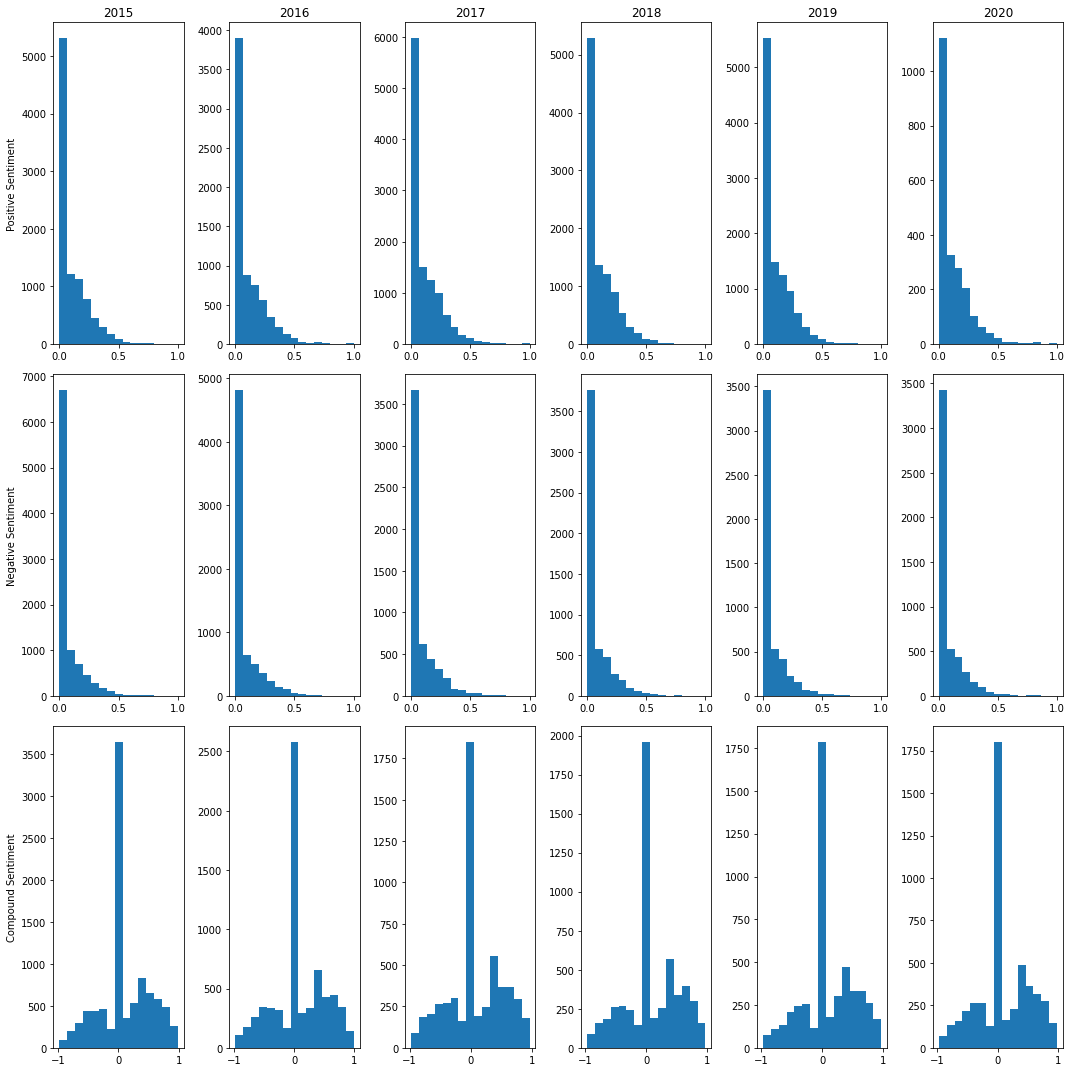

In [42]:
# Plot the sentiments for each year

fig=plt.figure(figsize= (15,15))

for i in range(6):
    ax1=fig.add_subplot(3,6,i+1)
    ax2=fig.add_subplot(3,6,i+7)
    ax3=fig.add_subplot(3,6,i+13)
    if (i == 0):
        ax1.set_ylabel("Positive Sentiment")
        ax2.set_ylabel("Negative Sentiment")
        ax3.set_ylabel("Compound Sentiment")
    ax1.hist(positive_sents[i], bins = 15)
    ax2.hist(negative_sents[i], bins = 15)
    ax3.hist(compound_sents[i], bins = 15)
    ax1.set_title("{}".format(i+2015))
        
fig.tight_layout() 
plt.show()